In [15]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
import pickle 
pd.options.mode.chained_assignment = None 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import cv2
import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from collections import OrderedDict
import pyarrow.parquet as pa
from tensorflow.keras import layers, regularizers, Model, metrics

In [2]:
#df for 64 embeddings
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_embeddings.pkl')

In [3]:
df

,mp3_path,tags,caption_writing,caption_embedding
0,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...,"[52.000892639160156, 28.640304565429688, 34.22..."
1,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...,"[41.24440002441406, 41.702205657958984, 49.210..."
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...,"[49.760990142822266, 39.03318786621094, 39.876..."
3,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...,"[74.27188110351562, 52.33830261230469, 113.251..."
4,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...,"[37.00017547607422, 0.0, 132.0074920654297, 71..."
...,...,...,...,...
11821,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical guitar solo piece features intr...,"[94.79190826416016, 0.0, 19.968608856201172, 7..."
11822,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This beautiful classical piece features a haun...,"[74.07515716552734, 20.25941276550293, 33.8745..."
11823,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical piece features beautiful melodi...,"[76.3675308227539, 31.28574562072754, 26.47723..."
11824,jacob_heringman-blame_not_my_lute-57-lost_is_m...,classical,This beautiful classical piece features a gent...,"[77.44381713867188, 22.265329360961914, 31.762..."


## Training the model

In [4]:
# data = np.load('data/magnatagatune/saved_df_data/data_array.npy')
data = np.load('/home/mendu/Thesis/data/magnatagatune/saved_df_data/data_array.npy')

In [5]:
# Caption Embeddings
embeddings = df['caption_embedding']

In [6]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255, 1)

In [7]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, embeddings, test_size=0.1, random_state=42)

In [9]:
y_train.shape

(10643,)

In [10]:
# Now, convert this array of arrays into a proper 2D NumPy array
y_train_array = np.stack(y_train, axis=0)

# Check the new shape to ensure it's (450, 64)
print("Shape after conversion:", y_train_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
y_train_tensor = tf.convert_to_tensor(y_train_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", y_train_tensor.shape)

Shape after conversion: (10643, 64)
Tensor shape: (10643, 64)


2024-07-12 07:59:49.696599: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
# Convert the 1D array of arrays into a proper 2D NumPy array
y_val_array = np.stack(y_val, axis=0)

# Check the new shape to ensure it's in the correct format
print("Shape after conversion:", y_val_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
y_val_tensor = tf.convert_to_tensor(y_val_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", y_val_tensor.shape)

Shape after conversion: (1183, 64)
Tensor shape: (1183, 64)


In [12]:
# Convert training data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)

# Convert validation data to tensors
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)

In [13]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [16]:
data.shape

(11826, 128, 1255, 1)

In [17]:
class ModelSubClassing(Model):
    def __init__(self, l1_reg=0.01, l2_reg=0.001):
        super().__init__()
        
        # Define L1 and L2 regularizer
        self.l1_l2_regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        
        # Initialize layers as None
        self.conv1 = None
        self.max1 = None
        self.bn1 = None
        self.conv2 = None
        self.bn2 = None
        self.max2 = None
        self.drop1 = None
        self.conv3 = None
        self.bn3 = None
        self.max3 = None
        self.drop2 = None
        self.flatten = None
        self.dense128 = None
        self.dense128_activation = None
        self.dense128_do = None
        self.dense64 = None
        
        self.loss_tracker = metrics.Mean(name="loss")
        self.mse_metric = metrics.MeanSquaredError(name="mse")
        self.mae_metric = metrics.MeanAbsoluteError(name="mae")

    def build(self, input_shape):
        # Create layers
        self.conv1 = layers.Conv2D(32, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.max1  = layers.MaxPooling2D(3)
        self.bn1   = layers.BatchNormalization(momentum=0.9)

        self.conv2 = layers.Conv2D(64, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.bn2   = layers.BatchNormalization(momentum=0.9)
        self.max2  = layers.MaxPooling2D(3)
        self.drop1 = layers.Dropout(0.3)

        self.conv3 = layers.Conv2D(128, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.bn3   = layers.BatchNormalization(momentum=0.9)
        self.max3  = layers.MaxPooling2D(3)
        self.drop2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense128 = layers.Dense(128)
        self.dense128_activation = layers.Activation('relu')
        self.dense128_do = layers.Dropout(0.3)
        self.dense64 = layers.Dense(64)
        
        super().build(input_shape)

    def call(self, inputs, training=None):
        # Forward pass: block 1
        x = self.conv1(inputs)
        x = self.max1(x)
        x = self.bn1(x, training=training)

        # Forward pass: block 2
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.max2(x)
        x = self.drop1(x, training=training)

        # Forward pass: block 3
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.max3(x)
        x = self.drop2(x, training=training)

        # Flatten and dense layers
        x = self.flatten(x)
        x_dense128 = self.dense128(x)
        x_dense128_act = self.dense128_activation(x_dense128)
        x_dense128_act = self.dense128_do(x_dense128_act, training=training)
        x_dense64 = self.dense64(x_dense128_act)

        return x_dense64

    def train_step(self, data):
        # Unpack the data
        mel_spectrogram, y = data

        with tf.GradientTape() as tape:
            y_pred = self(mel_spectrogram, training=True)  # Forward pass
            # Compute the standard loss value
            loss = self.compiled_loss(y, y_pred)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(loss)
        self.mse_metric.update_state(y, y_pred)
        self.mae_metric.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "mse": self.mse_metric.result(),
            "mae": self.mae_metric.result(),
        }

    def test_step(self, data):
        # Unpack the data
        mel_spectrogram, y = data

        y_pred = self(mel_spectrogram, training=False)  # Forward pass
        # Compute the standard loss value
        loss = self.compiled_loss(y, y_pred)

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(loss)
        self.mse_metric.update_state(y, y_pred)
        self.mae_metric.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "mse": self.mse_metric.result(),
            "mae": self.mae_metric.result(),
        }

    @property
    def metrics(self):
        # List all metrics to be reset after each epoch
        return [self.loss_tracker, self.mse_metric, self.mae_metric]

# Creating the class object
model = ModelSubClassing()

# Compile the model
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_opt, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])


In [18]:
early_stopper = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True)
rlronp = ReduceLROnPlateau(monitor="val_loss", factor=0.6, patience=10, verbose=1)

history = model.fit(
    X_train,
    y_train_tensor,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_tensor),
    callbacks = [early_stopper, rlronp]
)

Epoch 1/100


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:612: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


333/333 ━━━━━━━━━━━━━━━━━━━━ 110s 323ms/step - loss: 5571.1997 - mae: 57.5436 - mse: 5541.2646 - val_loss: 5864.2339 - val_mae: 58.6802 - val_mse: 5834.3574 - learning_rate: 1.0000e-04
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 107s 322ms/step - loss: 2451.1628 - mae: 38.2576 - mse: 2421.3257 - val_loss: 4287.0635 - val_mae: 47.7412 - val_mse: 4257.4717 - learning_rate: 1.0000e-04
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 107s 322ms/step - loss: 2012.6549 - mae: 34.3612 - mse: 1983.0546 - val_loss: 3593.7991 - val_mae: 44.0618 - val_mse: 3564.4255 - learning_rate: 1.0000e-04
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 107s 322ms/step - loss: 1830.0302 - mae: 32.4905 - mse: 1800.6877 - val_loss: 3823.2915 - val_mae: 45.5613 - val_mse: 3793.8828 - learning_rate: 1.0000e-04
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 107s 322ms/step - loss: 1703.4301 - mae: 31.1573 - mse: 1674.3358 - val_loss: 3076.5886 - val_mae: 39.5231 - val_mse: 3047.4592 - learning_rate: 1.0000e-04
Epoch 6/100
333/333 ━━━━━━━

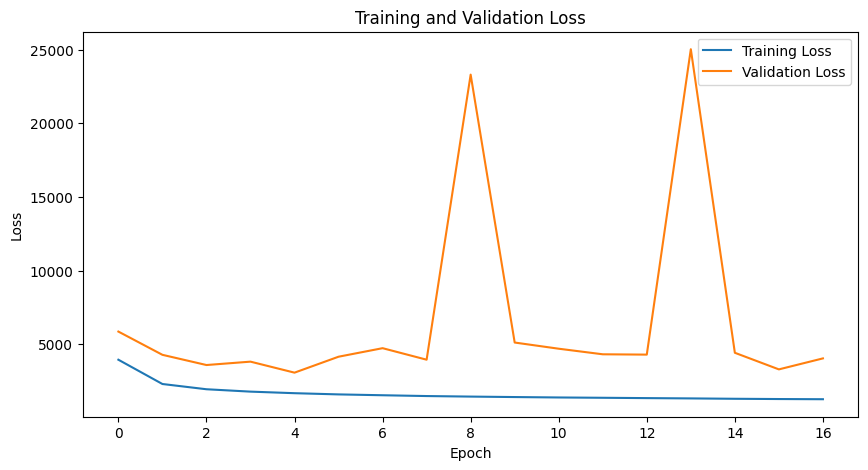

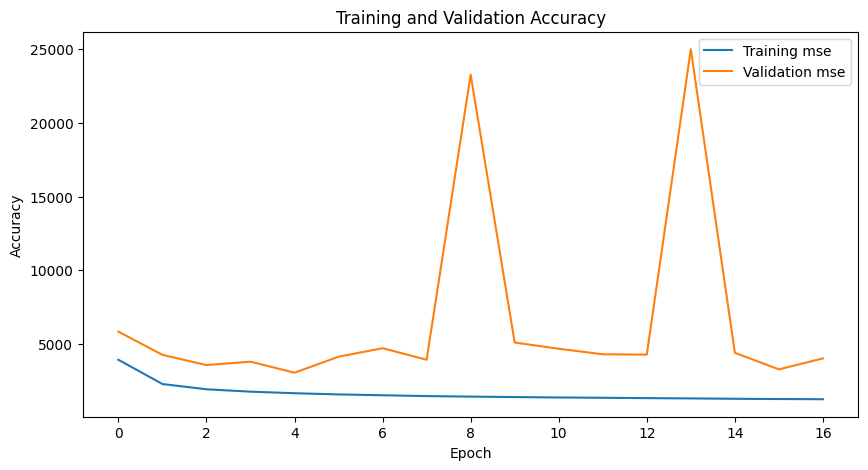

In [19]:
# Plot a graph for training and validation loss
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a graph for training and validation accuracy
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['mse'], label='Training mse')
plt.plot(history.history['val_mse'], label='Validation mse')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


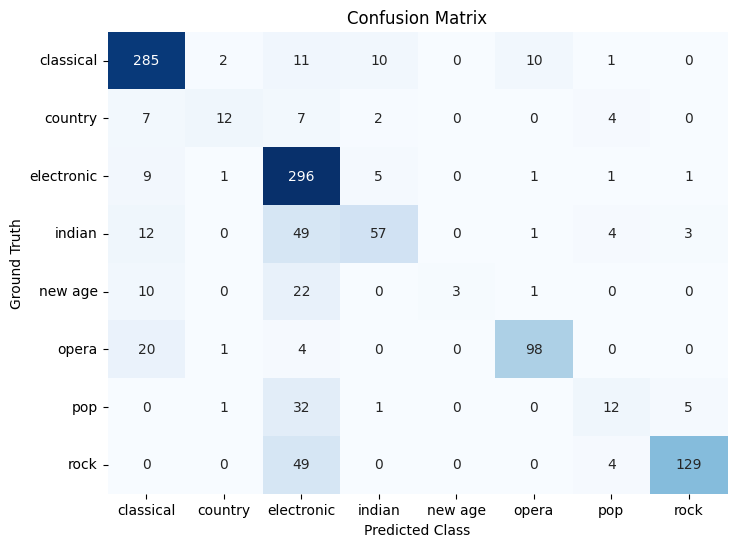

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predictions = model.predict((X_val_spec, y_val_tensor))
predicted_labels = np.argmax(predictions[0], axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

# Define class labels
class_labels = ['classical', 'country', 'electronic', 'indian',
                'new age', 'opera', 'pop', 'rock']

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Create a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})
# Get unique class labels
unique_labels = sorted(comparison_table['Ground Truth'].unique())

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# evaluate manually
train_loss, train_accuracy = model.evaluate((X_train_spec, y_train_tensor), y_train, verbose=0)
val_loss, val_accuracy = model.evaluate((X_val_spec, y_val_tensor), y_val, verbose=0)
print(f"Training accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}")
print(f"Training loss: {train_loss}, Validation loss: {val_loss}")

Training accuracy: 0.796392023563385, Validation accuracy: 0.7540152072906494
Training loss: 3.863865613937378, Validation loss: 4.049700736999512


In [19]:
# saving the histories in a pickle file
with open('/home/mendu/Thesis/data/magnatagatune/saved_history_dictionaries/history_dict_re9.pkl', 'wb') as f:
    pickle.dump(history.history, f)